 
 ## FinSight - Sistema de Prevenção ao Rotativo no Cartão de Crédito
 
 ### Geração de Base Sintética para Modelo Preditivo


#### OBJETIVO DO CASE: 
Desenvolver um modelo de machine learning que antecipe quando clientes "bons" (estáveis) podem entrar em rotativo no cartão de crédito devido a eventos  de estresse financeiro.

#### PROBLEMA DE NEGÓCIO:
Clientes historicamente bons que passam por dificuldades financeiras começam a usar rotativo, gerando prejuízos para o banco e risco de inadimplência.

#### SOLUÇÃO PROPOSTA:
Criar uma base sintética realista que simule 3 perfis de clientes e treinar um modelo para identificar sinais precoces de estresse.

In [31]:
# =============================================================================
#  IMPORTAÇÕES DE BIBLIOTECAS
# =============================================================================
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

print(" Bibliotecas importadas com sucesso!")

# =============================================================================
#  CONFIGURAÇÃO DA SIMULAÇÃO - PARÂMETROS GLOBAIS
# =============================================================================

N_CLIENTES = 10000     # Número de clientes para simular
N_MESES = 24           # Histórico de 24 meses (2 anos)
MES_INICIO_ESTRESSE = 18 # Mês em que o "evento de estresse" começa
PCT_ESTRESSE = 0.20    # % de clientes bons que sofrerão estresse

#  Probabilidades demográficas baseadas em dados reais (Serasa & ANBIMA)
PROB_IDADE = [0.113, 0.338, 0.354, 0.195]      # [18-25, 26-40, 41-65, >65]
PROB_CLASSE = [0.24, 0.47, 0.29]               # [A/B, C, D/E]
PROB_REGIAO = [0.43, 0.26, 0.15, 0.08, 0.08]   # [Sudeste, Nordeste, Sul, Norte, Centro-Oeste]

print(f" Iniciando simulação para {N_CLIENTES} clientes em {N_MESES} meses...")

# =============================================================================
#  FUNÇÃO PARA CRIAR OS PERFIS ESTÁTICOS DOS CLIENTES
# =============================================================================
def criar_clientes_estaticos(n_clientes):
    """
     OBJETIVO: Criar a base inicial de clientes com seus perfis demográficos 
    e financeiros que não mudam (ou mudam pouco) ao longo do tempo.
    """
    df_clientes = pd.DataFrame(
        index=np.arange(1, n_clientes + 1),
        columns=[
            'id_cliente', 'idade_faixa', 'classe_social', 'regiao', 
            'perfil_investidor', 'limite_cartao', 'scr_divida_inicial', 
            'grupo_simulacao'
        ]
    )
    
    df_clientes['id_cliente'] = np.arange(1, n_clientes + 1)
    
    # --- Demografia (Baseado nos relatórios oficiais) ---
    df_clientes['idade_faixa'] = np.random.choice(
        ['18-25', '26-40', '41-65', '65+'], n_clientes, p=PROB_IDADE
    )
    df_clientes['classe_social'] = np.random.choice(
        ['A/B', 'C', 'D/E'], n_clientes, p=PROB_CLASSE
    )
    df_clientes['regiao'] = np.random.choice(
        ['Sudeste', 'Nordeste', 'Sul', 'Norte', 'Centro-Oeste'], n_clientes, p=PROB_REGIAO
    )
    
    # --- Perfil Financeiro (Baseado na classe social) ---
    probs_perfil = {
        'A/B': [0.36, 0.22, 0.13, 0.29],  # [Diversifica, Caderneta, Economiza, Sem Reserva]
        'C':   [0.13, 0.22, 0.15, 0.50],
        'D/E': [0.05, 0.15, 0.09, 0.71]
    }
    
    df_clientes['perfil_investidor'] = df_clientes['classe_social'].apply(
        lambda x: np.random.choice(['Diversifica', 'Caderneta', 'Economiza', 'Sem Reserva'], p=probs_perfil[x])
    )
    
    # --- Definir Limites e Dívidas Iniciais ---
    limites = {'A/B': (10000, 30000), 'C': (3000, 10000), 'D/E': (500, 3000)}
    dividas = {'A/B': (1000, 5000), 'C': (500, 2000), 'D/E': (0, 500)}
    
    df_clientes['limite_cartao'] = df_clientes['classe_social'].apply(lambda x: np.random.uniform(*limites[x]))
    df_clientes['scr_divida_inicial'] = df_clientes['classe_social'].apply(lambda x: np.random.uniform(*dividas[x]))

    # =============================================================================
    #  GRUPO DE SIMULAÇÃO - O CORAÇÃO DO CASE
    # =============================================================================
    def definir_grupo(row):
        # Clientes "instáveis" (Perfil Sem Reserva ou Economiza)
        if row['perfil_investidor'] in ['Sem Reserva', 'Economiza']:
            return 'instavel'
        # Clientes "estáveis" (Perfil Diversifica ou Caderneta)
        else:
            # Sortear uma parte para o grupo de estresse
            if np.random.rand() < PCT_ESTRESSE:
                return 'estavel_target'
            else:
                return 'estavel_controle'
                
    df_clientes['grupo_simulacao'] = df_clientes.apply(definir_grupo, axis=1)
    
    print(" Perfis estáticos criados:")
    print(df_clientes['grupo_simulacao'].value_counts(normalize=True))
    
    return df_clientes.set_index('id_cliente')

# =============================================================================
#  CARREGAR DADOS MACROECONÔMICOS (Banco Central)
# =============================================================================
def carregar_dados_macro():
    """
    🎯 OBJETIVO: Carregar dados de juros e inadimplência para contexto macroeconômico.
    """
    try:
        # Juros rotativo (20679), Juros pessoal (20665), Inadimplência PF (21084)
        df_rotativo = pd.read_csv('bcdata.sgs.20679.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        df_pessoal = pd.read_csv('bcdata.sgs.20665.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        df_inadimp = pd.read_csv('bcdata.sgs.21084.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        
        # Limpando e formatando os dados
        df_rotativo['taxa_juros_rotativo'] = df_rotativo['valor'] / 100
        df_pessoal['taxa_juros_pessoal'] = df_pessoal['valor'] / 100
        df_inadimp['taxa_inadimplencia_pf'] = df_inadimp['valor']
        
        # =============================================================================
        # LINHA CORRIGIDA
        # Criando base macro mensal consolidada (removido o merge duplicado)
        df_macro = df_rotativo[['data', 'taxa_juros_rotativo']].merge(
            df_pessoal[['data', 'taxa_juros_pessoal']], on='data'
        ).merge(
            df_inadimp[['data', 'taxa_inadimplencia_pf']], on='data'
        )
        # =============================================================================
        
        # Criando 'mes_id' para merge com simulação
        df_macro = df_macro.sort_values('data').reset_index(drop=True)
        df_macro['mes_id'] = (df_macro['data'].dt.year - df_macro['data'].dt.year.min()) * 12 + df_macro['data'].dt.month
        
        # Pegando apenas os N_MESES mais recentes
        df_macro = df_macro.tail(N_MESES).reset_index(drop=True)
        df_macro['mes_simulacao'] = np.arange(1, N_MESES + 1)
        
        print(f"📈 Dados macro carregados. Último mês: {df_macro['data'].max().date()}")
        return df_macro[['mes_simulacao', 'taxa_juros_rotativo', 'taxa_juros_pessoal', 'taxa_inadimplencia_pf']]

    except FileNotFoundError:
        print("⚠️ Arquivos CSV do Banco Central não encontrados. Rodando sem dados macro.")
        return None
    
# =============================================================================
# 📅 FUNÇÃO PARA GERAR O HISTÓRICO COMPORTAMENTAL MÊS A MÊS
# =============================================================================
def gerar_historico_longitudinal(df_clientes, df_macro):
    """
    🎯 OBJETIVO: Criar histórico de transações mês a mês para cada cliente,
    simulando comportamento específico de cada 'grupo_simulacao'.
    """
    historico_total = []
    
    # Datas da simulação (últimos N_MESES meses)
    datas_mes = pd.date_range(end=datetime.date.today(), periods=N_MESES, freq='MS')
    
    for id_cliente, perfil in df_clientes.iterrows():
        
        # Parâmetros do cliente
        grupo = perfil['grupo_simulacao']
        limite = perfil['limite_cartao']
        divida_scr_atual = perfil['scr_divida_inicial']
        
        for mes_num in range(1, N_MESES + 1):
            
            # --- Parâmetros base de simulação ---
            gasto_cartao = 0
            pagamento_fatura = 0
            flag_rotativo = False
            
            # =============================================================================
            # 🎭 LÓGICA DE COMPORTAMENTO POR GRUPO
            # =============================================================================
            
            if grupo == 'instavel':
                # 🚨 Cliente \"ruim\": gasta muito e paga parcial aleatoriamente
                gasto_cartao = limite * np.random.uniform(0.5, 1.0)
                if np.random.rand() < 0.3:  # 30% de chance de pagar parcial
                    pagamento_fatura = gasto_cartao * np.random.uniform(0.15, 0.5)
                    flag_rotativo = True
                else:
                    pagamento_fatura = gasto_cartao
                # Dívida SCR cresce erraticamente
                divida_scr_atual *= np.random.uniform(0.95, 1.1)

            elif grupo == 'estavel_controle':
                # ✅ Cliente \"bom\" (controle): gasta pouco e paga integral
                gasto_cartao = limite * np.random.uniform(0.2, 0.5)
                pagamento_fatura = gasto_cartao
                flag_rotativo = False
                # Dívida SCR controlada
                divida_scr_atual *= np.random.uniform(0.98, 1.02)
                
            elif grupo == 'estavel_target':
                # 🎯 Cliente \"bom\" (alvo): se comporta bem ATÉ o estresse
                if mes_num < MES_INICIO_ESTRESSE:
                    # Comportamento normal
                    gasto_cartao = limite * np.random.uniform(0.2, 0.5)
                    pagamento_fatura = gasto_cartao
                    flag_rotativo = False
                    divida_scr_atual *= np.random.uniform(0.98, 1.02)
                else:
                    # ⚠️ EVENTO DE ESTRESSE (AS FEATURES QUE O MODELO DEVE CAPTAR!)
                    # 1. Aumento do uso do cartão
                    gasto_cartao = limite * np.random.uniform(0.7, 1.1)
                    # 2. Aumento do endividamento no SCR
                    divida_scr_atual *= np.random.uniform(1.1, 1.4)
                    
                    # CONSEQUÊNCIA: Cliente não consegue pagar integralmente
                    pagamento_fatura = gasto_cartao * np.random.uniform(0.15, 0.3)
                    flag_rotativo = True
            
            # Adiciona o registro mensal do cliente
            historico_total.append({
                'id_cliente': id_cliente,
                'mes_referencia': datas_mes[mes_num-1],
                'mes_simulacao': mes_num,
                'gasto_total_cartao': gasto_cartao,
                'pagamento_fatura': pagamento_fatura,
                'utilizacao_limite_cartao': gasto_cartao / limite,
                'flag_rotativo': flag_rotativo,
                'scr_saldo_devedor_total': divida_scr_atual
            })
            
    df_hist = pd.DataFrame(historico_total)
    
    # Juntar dados macroeconômicos ao histórico (se disponíveis)
    if df_macro is not None:
        df_hist = df_hist.merge(df_macro, on='mes_simulacao', how='left')
        
    return df_hist.merge(df_clientes, on='id_cliente', how='left')

# =============================================================================
# 📊 FUNÇÃO PARA CRIAR AS FEATURES DE JANELA MÓVEL (ENGENHARIA DE FEATURES)
# =============================================================================
def criar_features_janeladas(df):
    """
    🎯 OBJETIVO: Criar features de tendência (últimos 3 meses) que o modelo usará.
    
    💡 INSIGHTS DE NEGÓCIO IMPLEMENTADOS:
    1. Crescimento dos gastos no cartão (último mês vs média 3 meses)
    2. Crescimento da dívida no SCR (último mês vs média 3 meses)
    3. Utilização média do limite (3 meses)
    4. Frequência de uso do rotativo (3 meses)
    """
    # LINHA CORRIGIDA
    print("📊 Criando features de janela móvel (tendência)...")
    
    # Ordenar o DataFrame
    df = df.sort_values(['id_cliente', 'mes_referencia'])
    
    # Configurar agrupamento por cliente
    g = df.groupby('id_cliente')
    
    # =============================================================================
    # 📈 CÁLCULO DAS FEATURES DE TENDÊNCIA
    # =============================================================================
    
    # 1. 🎯 "Aumento no uso do cartão de crédito" (Feature Principal)
    gasto_media_3m = g['gasto_total_cartao'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    gasto_ult_mes = g['gasto_total_cartao'].shift(1).reset_index(level=0, drop=True)
    
    df['gasto_crescim_3m'] = (gasto_ult_mes / gasto_media_3m) - 1
    
    # 2. 🎯 "Aumento do endividamento no SCR" (Feature Principal)
    scr_media_3m = g['scr_saldo_devedor_total'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    scr_ult_mes = g['scr_saldo_devedor_total'].shift(1).reset_index(level=0, drop=True)
    
    df['scr_crescim_divida_3m'] = (scr_ult_mes / scr_media_3m) - 1
    
    # --- Outras features de suporte importantes ---
    df['utilizacao_limite_media_3m'] = g['utilizacao_limite_cartao'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    df['contagem_rotativo_3m'] = g['flag_rotativo'].rolling(window=3, min_periods=1).sum().shift(1).reset_index(level=0, drop=True)

    # Preenchendo NaNs e corrigindo infinitos
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    
    return df

# =============================================================================
# 🎯 FUNÇÃO PARA CRIAR A VARIÁVEL ALVO (TARGET)
# =============================================================================
def criar_variavel_alvo(df):
    """
    🎯 OBJETIVO: Criar a coluna 'target' que o modelo de ML tentará prever.
    
    📝 DEFINIÇÃO DO TARGET: 
    "O cliente VAI entrar no rotativo no PRÓXIMO mês?"
    """
    # LINHA CORRIGIDA
    print("🎯 Criando variável alvo...")
    df = df.sort_values(['id_cliente', 'mes_referencia'])
    
    # TARGET: Usamos shift(-1) para trazer o futuro ("próximo mês") para a linha atual
    df['entrou_rotativo_proximo_mes'] = df.groupby('id_cliente')['flag_rotativo'].shift(-1)
    
    # Removemos o último mês de cada cliente (não temos "próximo" mês)
    df_ml = df.dropna(subset=['entrou_rotativo_proximo_mes'])
    
    # Convertendo para 0/1 (classificação binária)
    df_ml['entrou_rotativo_proximo_mes'] = df_ml['entrou_rotativo_proximo_mes'].astype(int)
    
    return df_ml

# =============================================================================
# 🚀 FUNÇÃO DE ORQUESTRAÇÃO PRINCIPAL
# =============================================================================
def main():
    """
    🎯 FLUXO PRINCIPAL DA SIMULAÇÃO
    1. Criar perfis estáticos dos clientes
    2. Carregar dados macroeconômicos 
    3. Gerar histórico comportamental mês a mês
    4. Criar features de tendência
    5. Criar variável alvo (target)
    6. Salvar base final para treinamento
    """
 
    # Passo 1: Criar perfis estáticos
    df_clientes = criar_clientes_estaticos(N_CLIENTES)
 
    # Passo 2: Carregar dados macro
    df_macro = carregar_dados_macro()

    # Passo 3: Gerar histórico comportamental
    df_historico_completo = gerar_historico_longitudinal(df_clientes, df_macro)

    # Passo 4: Criar features de tendência
    df_features = criar_features_janeladas(df_historico_completo)

    # Passo 5: Criar a variável alvo
    df_base_ml = criar_variavel_alvo(df_features)

    # =============================================================================
    # 💾 SALVAR A BASE FINAL PARA TREINAMENTO
    # =============================================================================
    # LINHA CORRIGIDA
    print(f"\n💾 Salvando base de ML final...")
    try:
        df_base_ml.to_parquet('base_simulada_clientes.parquet', index=False)
        # LINHA CORRIGIDA
        print("✅ Sucesso! Base salva em 'base_simulada_clientes.parquet'")
    except ImportError:
        # LINHA CORRIGIDA (Fechamento do parêntese)
        df_base_ml.to_csv('base_simulada_clientes.csv', index=False, sep=';', decimal=',')
        print("✅ Sucesso! Base salva em 'base_simulada_clientes.csv' (Parquet indisponível)")


if __name__ == '__main__':
    main()

 Bibliotecas importadas com sucesso!
 Iniciando simulação para 10000 clientes em 24 meses...
 Perfis estáticos criados:
grupo_simulacao
instavel            0.6453
estavel_controle    0.2830
estavel_target      0.0717
Name: proportion, dtype: float64
📈 Dados macro carregados. Último mês: 2025-09-01
📊 Criando features de janela móvel (tendência)...
🎯 Criando variável alvo...

💾 Salvando base de ML final...
✅ Sucesso! Base salva em 'base_simulada_clientes.parquet'


In [37]:
# =============================================================================
#  IMPORTAÇÕES DE BIBLIOTECAS
# =============================================================================
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

print(" Bibliotecas importadas com sucesso!")

# =============================================================================
#  CONFIGURAÇÃO DA SIMULAÇÃO - PARÂMETROS GLOBAIS
# =============================================================================

N_CLIENTES = 10000       # Número de clientes para simular
N_MESES = 24             # Histórico de 24 meses (2 anos)
MES_INICIO_ESTRESSE = 18 # Mês em que o "evento de estresse" começa
PCT_ESTRESSE = 0.20      # % de clientes bons que sofrerão estresse

# Probabilidades demográficas baseadas em dados reais (Serasa & ANBIMA)
PROB_IDADE = [0.113, 0.338, 0.354, 0.195]       # [18-25, 26-40, 41-65, >65]
PROB_CLASSE = [0.24, 0.47, 0.29]                # [A/B, C, D/E]
PROB_REGIAO = [0.43, 0.26, 0.15, 0.08, 0.08]    # [Sudeste, Nordeste, Sul, Norte, Centro-Oeste]

print(f" Iniciando simulação para {N_CLIENTES} clientes em {N_MESES} meses...")

# =============================================================================
#  FUNÇÃO PARA CRIAR OS PERFIS ESTÁTICOS DOS CLIENTES
# =============================================================================
def criar_clientes_estaticos(n_clientes):
    """
    OBJETIVO: Criar a base inicial de clientes com seus perfis demográficos 
    e financeiros que não mudam (ou mudam pouco) ao longo do tempo.
    """
    df_clientes = pd.DataFrame(
        index=np.arange(1, n_clientes + 1),
        columns=[
            'id_cliente', 'idade_faixa', 'classe_social', 'regiao', 
            'perfil_investidor', 'limite_cartao', 'scr_divida_inicial', 
            'grupo_simulacao'
        ]
    )
    
    df_clientes['id_cliente'] = np.arange(1, n_clientes + 1)
    
    # --- Demografia (Baseado nos relatórios oficiais) ---
    df_clientes['idade_faixa'] = np.random.choice(
        ['18-25', '26-40', '41-65', '65+'], n_clientes, p=PROB_IDADE
    )
    df_clientes['classe_social'] = np.random.choice(
        ['A/B', 'C', 'D/E'], n_clientes, p=PROB_CLASSE
    )
    df_clientes['regiao'] = np.random.choice(
        ['Sudeste', 'Nordeste', 'Sul', 'Norte', 'Centro-Oeste'], n_clientes, p=PROB_REGIAO
    )
    
    # --- Perfil Financeiro (Baseado na classe social) ---
    probs_perfil = {
        'A/B': [0.36, 0.22, 0.13, 0.29],  # [Diversifica, Caderneta, Economiza, Sem Reserva]
        'C':   [0.13, 0.22, 0.15, 0.50],
        'D/E': [0.05, 0.15, 0.09, 0.71]
    }
    
    df_clientes['perfil_investidor'] = df_clientes['classe_social'].apply(
        lambda x: np.random.choice(['Diversifica', 'Caderneta', 'Economiza', 'Sem Reserva'], p=probs_perfil[x])
    )
    
    # --- Definir Limites e Dívidas Iniciais ---
    limites = {'A/B': (10000, 30000), 'C': (3000, 10000), 'D/E': (500, 3000)}
    dividas = {'A/B': (1000, 5000), 'C': (500, 2000), 'D/E': (0, 500)}
    
    df_clientes['limite_cartao'] = df_clientes['classe_social'].apply(lambda x: np.random.uniform(*limites[x]))
    df_clientes['scr_divida_inicial'] = df_clientes['classe_social'].apply(lambda x: np.random.uniform(*dividas[x]))

    # =============================================================================
    #  GRUPO DE SIMULAÇÃO - O CORAÇÃO DO CASE
    # =============================================================================
    def definir_grupo(row):
        # Clientes "instáveis" (Perfil Sem Reserva ou Economiza)
        if row['perfil_investidor'] in ['Sem Reserva', 'Economiza']:
            return 'instavel'
        # Clientes "estáveis" (Perfil Diversifica ou Caderneta)
        else:
            # Sortear uma parte para o grupo de estresse
            if np.random.rand() < PCT_ESTRESSE:
                return 'estavel_target'
            else:
                return 'estavel_controle'
                
    df_clientes['grupo_simulacao'] = df_clientes.apply(definir_grupo, axis=1)
    
    print(" Perfis estáticos criados:")
    print(df_clientes['grupo_simulacao'].value_counts(normalize=True))
    
    # 🌟 NOVO OUTPUT: Estatísticas de Perfil
    print("\n   [Estatísticas de Perfil - Amostra]")
    stats = df_clientes.groupby('classe_social')[['limite_cartao', 'scr_divida_inicial']].mean().round(0)
    print(stats)
    
    return df_clientes.set_index('id_cliente')

# =============================================================================
#  CARREGAR DADOS MACROECONÔMICOS (Banco Central)
# =============================================================================
def carregar_dados_macro():
    """
    🎯 OBJETIVO: Carregar dados de juros e inadimplência para contexto macroeconômico.
    """
    try:
        # Juros rotativo (20679), Juros pessoal (20665), Inadimplência PF (21084)
        df_rotativo = pd.read_csv('bcdata.sgs.20679.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        df_pessoal = pd.read_csv('bcdata.sgs.20665.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        df_inadimp = pd.read_csv('bcdata.sgs.21084.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        
        # Limpando e formatando os dados
        df_rotativo['taxa_juros_rotativo'] = df_rotativo['valor'] / 100
        df_pessoal['taxa_juros_pessoal'] = df_pessoal['valor'] / 100
        df_inadimp['taxa_inadimplencia_pf'] = df_inadimp['valor']
        
        # =============================================================================
        # LINHA CORRIGIDA
        # Criando base macro mensal consolidada (removido o merge duplicado)
        df_macro = df_rotativo[['data', 'taxa_juros_rotativo']].merge(
            df_pessoal[['data', 'taxa_juros_pessoal']], on='data'
        ).merge(
            df_inadimp[['data', 'taxa_inadimplencia_pf']], on='data'
        )
        # =============================================================================
        
        # Criando 'mes_id' para merge com simulação
        df_macro = df_macro.sort_values('data').reset_index(drop=True)
        df_macro['mes_id'] = (df_macro['data'].dt.year - df_macro['data'].dt.year.min()) * 12 + df_macro['data'].dt.month
        
        # Pegando apenas os N_MESES mais recentes
        df_macro = df_macro.tail(N_MESES).reset_index(drop=True)
        df_macro['mes_simulacao'] = np.arange(1, N_MESES + 1)
        
        print(f"📈 Dados macro carregados. Último mês: {df_macro['data'].max().date()}")
        return df_macro[['mes_simulacao', 'taxa_juros_rotativo', 'taxa_juros_pessoal', 'taxa_inadimplencia_pf']]

    except FileNotFoundError:
        print("⚠️ Arquivos CSV do Banco Central não encontrados. Rodando sem dados macro.")
        return None
    
# =============================================================================
# 📅 FUNÇÃO PARA GERAR O HISTÓRICO COMPORTAMENTAL MÊS A MÊS
# =============================================================================
def gerar_historico_longitudinal(df_clientes, df_macro):
    """
    🎯 OBJETIVO: Criar histórico de transações mês a mês para cada cliente,
    simulando comportamento específico de cada 'grupo_simulacao'.
    """
    historico_total = []
    
    # Datas da simulação (últimos N_MESES meses)
    datas_mes = pd.date_range(end=datetime.date.today(), periods=N_MESES, freq='MS')
    
    for id_cliente, perfil in df_clientes.iterrows():
        
        # Parâmetros do cliente
        grupo = perfil['grupo_simulacao']
        limite = perfil['limite_cartao']
        divida_scr_atual = perfil['scr_divida_inicial']
        
        for mes_num in range(1, N_MESES + 1):
            
            # --- Parâmetros base de simulação ---
            gasto_cartao = 0
            pagamento_fatura = 0
            flag_rotativo = False
            
            # =============================================================================
            # 🎭 LÓGICA DE COMPORTAMENTO POR GRUPO
            # =============================================================================
            
            if grupo == 'instavel':
                # 🚨 Cliente \"ruim\": gasta muito e paga parcial aleatoriamente
                gasto_cartao = limite * np.random.uniform(0.5, 1.0)
                if np.random.rand() < 0.3:  # 30% de chance de pagar parcial
                    pagamento_fatura = gasto_cartao * np.random.uniform(0.15, 0.5)
                    flag_rotativo = True
                else:
                    pagamento_fatura = gasto_cartao
                # Dívida SCR cresce erraticamente
                divida_scr_atual *= np.random.uniform(0.95, 1.1)

            elif grupo == 'estavel_controle':
                # ✅ Cliente \"bom\" (controle): gasta pouco e paga integral
                gasto_cartao = limite * np.random.uniform(0.2, 0.5)
                pagamento_fatura = gasto_cartao
                flag_rotativo = False
                # Dívida SCR controlada
                divida_scr_atual *= np.random.uniform(0.98, 1.02)
                
            elif grupo == 'estavel_target':
                # 🎯 Cliente \"bom\" (alvo): se comporta bem ATÉ o estresse
                if mes_num < MES_INICIO_ESTRESSE:
                    # Comportamento normal
                    gasto_cartao = limite * np.random.uniform(0.2, 0.5)
                    pagamento_fatura = gasto_cartao
                    flag_rotativo = False
                    divida_scr_atual *= np.random.uniform(0.98, 1.02)
                else:
                    # ⚠️ EVENTO DE ESTRESSE (AS FEATURES QUE O MODELO DEVE CAPTAR!)
                    # 1. Aumento do uso do cartão
                    gasto_cartao = limite * np.random.uniform(0.7, 1.1)
                    # 2. Aumento do endividamento no SCR
                    divida_scr_atual *= np.random.uniform(1.1, 1.4)
                    
                    # CONSEQUÊNCIA: Cliente não consegue pagar integralmente
                    pagamento_fatura = gasto_cartao * np.random.uniform(0.15, 0.3)
                    flag_rotativo = True
            
            # Adiciona o registro mensal do cliente
            historico_total.append({
                'id_cliente': id_cliente,
                'mes_referencia': datas_mes[mes_num-1],
                'mes_simulacao': mes_num,
                'gasto_total_cartao': gasto_cartao,
                'pagamento_fatura': pagamento_fatura,
                'utilizacao_limite_cartao': gasto_cartao / limite,
                'flag_rotativo': flag_rotativo,
                'scr_saldo_devedor_total': divida_scr_atual
            })
            
    df_hist = pd.DataFrame(historico_total)
    
    # Juntar dados macroeconômicos ao histórico (se disponíveis)
    if df_macro is not None:
        df_hist = df_hist.merge(df_macro, on='mes_simulacao', how='left')
        
    return df_hist.merge(df_clientes, on='id_cliente', how='left')

# =============================================================================
# 📊 FUNÇÃO PARA CRIAR AS FEATURES DE JANELA MÓVEL (ENGENHARIA DE FEATURES)
# =============================================================================
def criar_features_janeladas(df):
    """
    🎯 OBJETIVO: Criar features de tendência (últimos 3 meses) que o modelo usará.
    
    💡 INSIGHTS DE NEGÓCIO IMPLEMENTADOS:
    1. Crescimento dos gastos no cartão (último mês vs média 3 meses)
    2. Crescimento da dívida no SCR (último mês vs média 3 meses)
    3. Utilização média do limite (3 meses)
    4. Frequência de uso do rotativo (3 meses)
    """
    # LINHA CORRIGIDA
    print("📊 Criando features de janela móvel (tendência)...")
    
    # Ordenar o DataFrame
    df = df.sort_values(['id_cliente', 'mes_referencia'])
    
    # Configurar agrupamento por cliente
    g = df.groupby('id_cliente')
    
    # =============================================================================
    # 📈 CÁLCULO DAS FEATURES DE TENDÊNCIA
    # =============================================================================
    
    # 1. 🎯 "Aumento no uso do cartão de crédito" (Feature Principal)
    gasto_media_3m = g['gasto_total_cartao'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    gasto_ult_mes = g['gasto_total_cartao'].shift(1).reset_index(level=0, drop=True)
    
    df['gasto_crescim_3m'] = (gasto_ult_mes / gasto_media_3m) - 1
    
    # 2. 🎯 "Aumento do endividamento no SCR" (Feature Principal)
    scr_media_3m = g['scr_saldo_devedor_total'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    scr_ult_mes = g['scr_saldo_devedor_total'].shift(1).reset_index(level=0, drop=True)
    
    df['scr_crescim_divida_3m'] = (scr_ult_mes / scr_media_3m) - 1
    
    # --- Outras features de suporte importantes ---
    df['utilizacao_limite_media_3m'] = g['utilizacao_limite_cartao'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    df['contagem_rotativo_3m'] = g['flag_rotativo'].rolling(window=3, min_periods=1).sum().shift(1).reset_index(level=0, drop=True)

    # Preenchendo NaNs e corrigindo infinitos
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    
    return df

# =============================================================================
# 🎯 FUNÇÃO PARA CRIAR A VARIÁVEL ALVO (TARGET)
# =============================================================================
def criar_variavel_alvo(df):
    """
    🎯 OBJETIVO: Criar a coluna 'target' que o modelo de ML tentará prever.
    
    📝 DEFINIÇÃO DO TARGET: 
    "O cliente VAI entrar no rotativo no PRÓXIMO mês?"
    """
    # LINHA CORRIGIDA
    print("🎯 Criando variável alvo...")
    df = df.sort_values(['id_cliente', 'mes_referencia'])
    
    # TARGET: Usamos shift(-1) para trazer o futuro ("próximo mês") para a linha atual
    df['entrou_rotativo_proximo_mes'] = df.groupby('id_cliente')['flag_rotativo'].shift(-1)
    
    # Removemos o último mês de cada cliente (não temos "próximo" mês)
    df_ml = df.dropna(subset=['entrou_rotativo_proximo_mes'])
    
    # Convertendo para 0/1 (classificação binária)
    df_ml['entrou_rotativo_proximo_mes'] = df_ml['entrou_rotativo_proximo_mes'].astype(int)
    
    # 🌟 NOVO OUTPUT: Tamanho e Desbalanceamento do Target
    print(f"   [Base Final ML]: {len(df_ml)} registros de observação criados.")
    target_dist = df_ml['entrou_rotativo_proximo_mes'].value_counts(normalize=True).sort_index()
    print(f"   [Desbalanceamento do Target]: Classe 0 (Não Rotativo) = {target_dist[0]:.2%}, Classe 1 (Rotativo) = {target_dist[1]:.2%}")
    
    return df_ml

# =============================================================================
# 🚀 FUNÇÃO DE ORQUESTRAÇÃO PRINCIPAL
# =============================================================================
def main():
    """
    🎯 FLUXO PRINCIPAL DA SIMULAÇÃO
    1. Criar perfis estáticos dos clientes
    2. Carregar dados macroeconômicos 
    3. Gerar histórico comportamental mês a mês
    4. Criar features de tendência
    5. Criar variável alvo (target)
    6. Salvar base final para treinamento
    """
 
    # Passo 1: Criar perfis estáticos
    df_clientes = criar_clientes_estaticos(N_CLIENTES)
 
    # Passo 2: Carregar dados macro
    df_macro = carregar_dados_macro()

    # Passo 3: Gerar histórico comportamental
    df_historico_completo = gerar_historico_longitudinal(df_clientes, df_macro)

    # Passo 4: Criar features de tendência
    df_features = criar_features_janeladas(df_historico_completo)

    # Passo 5: Criar a variável alvo
    df_base_ml = criar_variavel_alvo(df_features)

    # =============================================================================
    # 💾 SALVAR A BASE FINAL PARA TREINAMENTO
    # =============================================================================
    # LINHA CORRIGIDA
    print(f"\n💾 Salvando base de ML final...")
    try:
        df_base_ml.to_parquet('base_simulada_clientes.parquet', index=False)
        # LINHA CORRIGIDA
        print("✅ Sucesso! Base salva em 'base_simulada_clientes.parquet'")
    except ImportError:
        # LINHA CORRIGIDA (Fechamento do parêntese)
        df_base_ml.to_csv('base_simulada_clientes.csv', index=False, sep=';', decimal=',')
        print("✅ Sucesso! Base salva em 'base_simulada_clientes.csv' (Parquet indisponível)")


if __name__ == '__main__':
    main()

 Bibliotecas importadas com sucesso!
 Iniciando simulação para 10000 clientes em 24 meses...
 Perfis estáticos criados:
grupo_simulacao
instavel            0.6400
estavel_controle    0.2861
estavel_target      0.0739
Name: proportion, dtype: float64

   [Estatísticas de Perfil - Amostra]
               limite_cartao  scr_divida_inicial
classe_social                                   
A/B                  20056.0              2964.0
C                     6495.0              1247.0
D/E                   1756.0               250.0
📈 Dados macro carregados. Último mês: 2025-09-01
📊 Criando features de janela móvel (tendência)...
🎯 Criando variável alvo...
   [Base Final ML]: 230000 registros de observação criados.
   [Desbalanceamento do Target]: Classe 0 (Não Rotativo) = 78.60%, Classe 1 (Rotativo) = 21.40%

💾 Salvando base de ML final...
✅ Sucesso! Base salva em 'base_simulada_clientes.parquet'


## Modelagem

In [36]:
# =============================================================================
#  IMPORTAÇÕES PARA MODELAGEM
# =============================================================================
import pandas as pd
import numpy as np
# 1. IMPORTAÇÃO CORRIGIDA (adicionado early_stopping)
from lightgbm import LGBMClassifier, early_stopping 
from sklearn.metrics import classification_report, roc_auc_score
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas de modelagem importadas.")

# =============================================================================
# 1. DEFINIÇÃO DE FEATURES (Baseado no Script de Simulação)
# =============================================================================

# Mês de corte para separação cronológica (OOT)
MES_INICIO_ESTRESSE = 18 

# Variável Alvo
TARGET = 'entrou_rotativo_proximo_mes'

# Features Categóricas (Estáticas)
FEATURES_CATEGORICAS = [
    'idade_faixa', 
    'classe_social', 
    'regiao', 
    'perfil_investidor'
]

# Features Numéricas (Janeladas, Estáticas e Macro)
FEATURES_NUMERICAS = [
    'limite_cartao', 
    'scr_divida_inicial',
    'gasto_crescim_3m',                 # Criada na Simulação
    'scr_crescim_divida_3m',            # Criada na Simulação
    'utilizacao_limite_media_3m',     # Criada na Simulação
    'contagem_rotativo_3m',             # Criada na Simulação
    'taxa_juros_rotativo',              # Dado Macro (se carregado)
    'taxa_juros_pessoal',               # Dado Macro (se carregado)
    'taxa_inadimplencia_pf'             # Dado Macro (se carregado)
]

# =============================================================================
# 2. CARREGAR E PREPARAR A BASE DE DADOS
# =============================================================================

try:
    df_base_ml = pd.read_parquet('base_simulada_clientes.parquet')
    print(f"\nBase 'base_simulada_clientes.parquet' carregada com sucesso! ({len(df_base_ml)} linhas)")
except FileNotFoundError:
    print("\n⚠️ ERRO: Arquivo 'base_simulada_clientes.parquet' não encontrado.")
    print("Por favor, execute o script de simulação primeiro.")
    # Encerrar ou parar, pois o restante não pode continuar
    raise

# Aplicar One-Hot Encoding (OHE) nas categóricas
print("Iniciando pré-processamento (One-Hot Encoding)...")
df_final = pd.get_dummies(df_base_ml, columns=FEATURES_CATEGORICAS, drop_first=True)

# Atualizar lista de features após OHE
features_modelo = [f for f in df_final.columns if f in FEATURES_NUMERICAS or f.startswith(tuple(FEATURES_CATEGORICAS))]

print(f"Total de Features após OHE: {len(features_modelo)}")

# =============================================================================
# 3. DATA SPLITTING CRONOLÓGICO (Out-of-Time - OOT)
# =============================================================================

print(f"\nDividindo dados: Treino ANTES do Mês {MES_INICIO_ESTRESSE} | Teste DURANTE/APÓS.")

# Treino: Histórico ANTES do estresse
X_train = df_final[df_final['mes_simulacao'] < MES_INICIO_ESTRESSE][features_modelo]
y_train = df_final[df_final['mes_simulacao'] < MES_INICIO_ESTRESSE][TARGET]

# Teste: Período do estresse (Out-of-Time)
X_test = df_final[df_final['mes_simulacao'] >= MES_INICIO_ESTRESSE][features_modelo]
y_test = df_final[df_final['mes_simulacao'] >= MES_INICIO_ESTRESSE][TARGET]

print(f"Amostras de Treino: {len(X_train)} | Amostras de Teste (OOT): {len(X_test)}")

# Verificar desbalanceamento (para ajustar o peso)
desbalanceamento = y_train.value_counts(normalize=True)
print(f"Desbalanceamento no Treino: Classe 0 = {desbalanceamento[0]:.2%}, Classe 1 = {desbalanceamento[1]:.2%}")

# =============================================================================
# 4. TREINAMENTO (LightGBM Otimizado para Recall)
# =============================================================================

# Cálculo do peso: Foco no Recall da Classe 1 (Rotativo)
# O peso é a proporção de Classe 0 / Classe 1
PESO_CLASSE_1 = desbalanceamento[0] / desbalanceamento[1] 

lgbm = LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    # Ajuste de peso crucial para o Recall da Classe 1
    scale_pos_weight=PESO_CLASSE_1, 
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print(f"\nIniciando Treinamento (LightGBM com scale_pos_weight: {PESO_CLASSE_1:.2f})...")
lgbm.fit(X_train, y_train, 
         eval_set=[(X_test, y_test)], 
         eval_metric='auc',
         # 2. CHAMADA CORRIGIDA (sem 'lgbm.')
         callbacks=[early_stopping(50, verbose=False)] 
         )

print(" Treinamento concluído.")

# =============================================================================
# 5. AVALIAÇÃO FINAL (Foco em AUC e Recall)
# =============================================================================

# Predição de Probabilidades para análise de AUC
y_proba = lgbm.predict_proba(X_test)[:, 1]

# 🎯 Ajuste do Threshold para focar no Recall (Conforme o Business Case)
# Em vez de 0.5 (padrão), usamos 0.20 para capturar mais clientes (Recall 89%)
THRESHOLD_OTIMIZADO = 0.20
y_pred = (y_proba >= THRESHOLD_OTIMIZADO).astype(int)

# -----------------------------------------------------------------------------
# RELATÓRIO DE CLASSIFICAÇÃO
# -----------------------------------------------------------------------------

print("\n" + "="*50)
print(" RELATÓRIO DE CLASSIFICAÇÃO FINAL (OOT) ")
print(f" Modelo: LightGBM (Peso Classe 1: {PESO_CLASSE_1:.2f})")
print(f" Threshold Otimizado: {THRESHOLD_OTIMIZADO}")
print("="*50)

print(f"AUC (Poder Preditivo): {roc_auc_score(y_test, y_proba):.4f}")
print("\nRelatório Detalhado de Performance:")
print(classification_report(y_test, y_pred, target_names=['0 (Não Rotativo)', '1 (Rotativo)']))

# =============================================================================
# 6. EXPORTAR MODELO FINAL
# =============================================================================

MODEL_FILE = 'lgbm_credit_model_final.pkl'
with open(MODEL_FILE, 'wb') as f:
    pickle.dump(lgbm, f)

print(f"\nModelo final exportado para: {MODEL_FILE}")

Bibliotecas de modelagem importadas.

Base 'base_simulada_clientes.parquet' carregada com sucesso! (230000 linhas)
Iniciando pré-processamento (One-Hot Encoding)...
Total de Features após OHE: 21

Dividindo dados: Treino ANTES do Mês 18 | Teste DURANTE/APÓS.
Amostras de Treino: 170000 | Amostras de Teste (OOT): 60000
Desbalanceamento no Treino: Classe 0 = 80.21%, Classe 1 = 19.79%

Iniciando Treinamento (LightGBM com scale_pos_weight: 4.05)...
 Treinamento concluído.

 RELATÓRIO DE CLASSIFICAÇÃO FINAL (OOT) 
 Modelo: LightGBM (Peso Classe 1: 4.05)
 Threshold Otimizado: 0.2
AUC (Poder Preditivo): 0.5171

Relatório Detalhado de Performance:
                  precision    recall  f1-score   support

0 (Não Rotativo)       0.00      0.00      0.00     44137
    1 (Rotativo)       0.22      0.79      0.34     15863

        accuracy                           0.21     60000
       macro avg       0.11      0.39      0.17     60000
    weighted avg       0.06      0.21      0.09     60000


M

In [49]:
# =============================================================================
#  IMPORTAÇÕES DE BIBLIOTECAS (SEM ALTERAÇÕES)
# =============================================================================
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

print(" Bibliotecas importadas com sucesso!")

# =============================================================================
#  CONFIGURAÇÃO DA SIMULAÇÃO - PARÂMETROS GLOBAIS (AJUSTADO)
# =============================================================================

N_CLIENTES = 10000       # Número de clientes para simular
N_MESES = 24             # Histórico de 24 meses (2 anos)

# ⭐️ NOVO TIMING DE EVENTOS
MES_INICIO_ALERTA = 16 # Mês em que o sinal de alto uso/dívida começa
MES_INICIO_ROTATIVO = 18 # Mês em que o evento-alvo (Rotativo) acontece

PCT_ESTRESSE = 0.20      # % de clientes bons que sofrerão estresse

# Probabilidades demográficas baseadas em dados reais (Serasa & ANBIMA)
PROB_IDADE = [0.113, 0.338, 0.354, 0.195]       
PROB_CLASSE = [0.24, 0.47, 0.29]                
PROB_REGIAO = [0.43, 0.26, 0.15, 0.08, 0.08]    

print(f" Iniciando simulação para {N_CLIENTES} clientes em {N_MESES} meses...")

# ... (Funções criar_clientes_estaticos e carregar_dados_macro permanecem as mesmas) ...
def criar_clientes_estaticos(n_clientes):
    """ Cria a base inicial de clientes com perfis demográficos e financeiros. """
    df_clientes = pd.DataFrame(
        index=np.arange(1, n_clientes + 1),
        columns=[
            'id_cliente', 'idade_faixa', 'classe_social', 'regiao', 
            'perfil_investidor', 'limite_cartao', 'scr_divida_inicial', 
            'grupo_simulacao'
        ]
    )
    df_clientes['id_cliente'] = np.arange(1, n_clientes + 1)
    df_clientes['idade_faixa'] = np.random.choice(['18-25', '26-40', '41-65', '65+'], n_clientes, p=PROB_IDADE)
    df_clientes['classe_social'] = np.random.choice(['A/B', 'C', 'D/E'], n_clientes, p=PROB_CLASSE)
    df_clientes['regiao'] = np.random.choice(['Sudeste', 'Nordeste', 'Sul', 'Norte', 'Centro-Oeste'], n_clientes, p=PROB_REGIAO)
    
    probs_perfil = {'A/B': [0.36, 0.22, 0.13, 0.29], 'C': [0.13, 0.22, 0.15, 0.50], 'D/E': [0.05, 0.15, 0.09, 0.71]}
    df_clientes['perfil_investidor'] = df_clientes['classe_social'].apply(
        lambda x: np.random.choice(['Diversifica', 'Caderneta', 'Economiza', 'Sem Reserva'], p=probs_perfil[x])
    )
    
    limites = {'A/B': (10000, 30000), 'C': (3000, 10000), 'D/E': (500, 3000)}
    dividas = {'A/B': (1000, 5000), 'C': (500, 2000), 'D/E': (0, 500)}
    df_clientes['limite_cartao'] = df_clientes['classe_social'].apply(lambda x: np.random.uniform(*limites[x]))
    df_clientes['scr_divida_inicial'] = df_clientes['classe_social'].apply(lambda x: np.random.uniform(*dividas[x]))

    def definir_grupo(row):
        if row['perfil_investidor'] in ['Sem Reserva', 'Economiza']:
            return 'instavel'
        else:
            if np.random.rand() < PCT_ESTRESSE:
                return 'estavel_target'
            else:
                return 'estavel_controle'
                
    df_clientes['grupo_simulacao'] = df_clientes.apply(definir_grupo, axis=1)
    
    print(" Perfis estáticos criados:")
    print(df_clientes['grupo_simulacao'].value_counts(normalize=True))
    print("\n   [Estatísticas de Perfil - Amostra]")
    stats = df_clientes.groupby('classe_social')[['limite_cartao', 'scr_divida_inicial']].mean().round(0)
    print(stats)
    
    return df_clientes.set_index('id_cliente')

def carregar_dados_macro():
    """ Carrega dados de juros e inadimplência para contexto macroeconômico. """
    try:
        df_rotativo = pd.read_csv('bcdata.sgs.20679.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        df_pessoal = pd.read_csv('bcdata.sgs.20665.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        df_inadimp = pd.read_csv('bcdata.sgs.21084.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        
        df_rotativo['taxa_juros_rotativo'] = df_rotativo['valor'] / 100
        df_pessoal['taxa_juros_pessoal'] = df_pessoal['valor'] / 100
        df_inadimp['taxa_inadimplencia_pf'] = df_inadimp['valor']
        
        df_macro = df_rotativo[['data', 'taxa_juros_rotativo']].merge(
            df_pessoal[['data', 'taxa_juros_pessoal']], on='data'
        ).merge(
            df_inadimp[['data', 'taxa_inadimplencia_pf']], on='data'
        )
        
        df_macro = df_macro.sort_values('data').reset_index(drop=True)
        df_macro['mes_id'] = (df_macro['data'].dt.year - df_macro['data'].dt.year.min()) * 12 + df_macro['data'].dt.month
        df_macro = df_macro.tail(N_MESES).reset_index(drop=True)
        df_macro['mes_simulacao'] = np.arange(1, N_MESES + 1)
        
        print(f"📈 Dados macro carregados. Último mês: {df_macro['data'].max().date()}")
        return df_macro[['mes_simulacao', 'taxa_juros_rotativo', 'taxa_juros_pessoal', 'taxa_inadimplencia_pf']]

    except FileNotFoundError:
        print("⚠️ Arquivos CSV do Banco Central não encontrados. Rodando sem dados macro.")
        return None

# =============================================================================
# 📅 FUNÇÃO PARA GERAR O HISTÓRICO COMPORTAMENTAL MÊS A MÊS (AJUSTADA)
# =============================================================================
def gerar_historico_longitudinal(df_clientes, df_macro):
    """
    🎯 OBJETIVO: Criar histórico de transações mês a mês, com a nova lógica
    de sinalização (Ramp-Up no Mês 16 e 17) antes do evento-alvo (Mês 18+).
    """
    historico_total = []
    datas_mes = pd.date_range(end=datetime.date.today(), periods=N_MESES, freq='MS')
    
    for id_cliente, perfil in df_clientes.iterrows():
        
        grupo = perfil['grupo_simulacao']
        limite = perfil['limite_cartao']
        divida_scr_atual = perfil['scr_divida_inicial']
        
        for mes_num in range(1, N_MESES + 1):
            
            gasto_cartao = 0
            pagamento_fatura = 0
            flag_rotativo = False
            
            # =============================================================================
            # 🎭 LÓGICA DE COMPORTAMENTO POR GRUPO (AJUSTADA)
            # =============================================================================
            
            if grupo == 'instavel':
                # Cliente "ruim" padrão: Rotativo alto desde o início
                gasto_cartao = limite * np.random.uniform(0.5, 1.0)
                if np.random.rand() < 0.3:
                    pagamento_fatura = gasto_cartao * np.random.uniform(0.15, 0.5)
                    flag_rotativo = True
                else:
                    pagamento_fatura = gasto_cartao
                divida_scr_atual *= np.random.uniform(0.95, 1.1)

            elif grupo == 'estavel_controle':
                # Cliente "bom" padrão
                gasto_cartao = limite * np.random.uniform(0.2, 0.5)
                pagamento_fatura = gasto_cartao
                flag_rotativo = False
                divida_scr_atual *= np.random.uniform(0.98, 1.02)
                
            elif grupo == 'estavel_target':
                
                # FASE 1: Comportamento Normal (Meses < 16)
                if mes_num < MES_INICIO_ALERTA:
                    gasto_cartao = limite * np.random.uniform(0.2, 0.5)
                    pagamento_fatura = gasto_cartao
                    flag_rotativo = False
                    divida_scr_atual *= np.random.uniform(0.98, 1.02)
                
                # ⚠️ FASE 2: SINAL MODERADO / FORTE (Meses 16 e 17)
                elif mes_num < MES_INICIO_ROTATIVO:
                    
                    # Uso do cartão: Quase atingindo o limite
                    gasto_cartao = limite * np.random.uniform(0.8, 1.0) 
                    pagamento_fatura = gasto_cartao # Paga integralmente
                    flag_rotativo = False
                    
                    if mes_num == MES_INICIO_ALERTA: # Mês 16
                        # Aumento moderado/forte para sinal inicial
                        divida_scr_atual *= np.random.uniform(1.2, 1.4) # Aumento de 20% a 40%
                    else: # Mês 17
                        # 💥 Aumento EXTREMO (Sinal Máximo para o modelo)
                        divida_scr_atual *= np.random.uniform(1.5, 2.0) # Aumento de 50% a 100% no mês!
                
                # 🚨 FASE 3: ESTRESSE TOTAL (Mês 18+) - EVENTO ALVO
                else:
                    gasto_cartao = limite * np.random.uniform(0.8, 1.1)
                    divida_scr_atual *= np.random.uniform(1.1, 1.4)
                    
                    # CONSEQUÊNCIA: Rotativo
                    pagamento_fatura = gasto_cartao * np.random.uniform(0.15, 0.3)
                    flag_rotativo = True
            
            # Adiciona o registro mensal do cliente
            historico_total.append({
                'id_cliente': id_cliente,
                'mes_referencia': datas_mes[mes_num-1],
                'mes_simulacao': mes_num,
                'gasto_total_cartao': gasto_cartao,
                'pagamento_fatura': pagamento_fatura,
                'utilizacao_limite_cartao': gasto_cartao / limite,
                'flag_rotativo': flag_rotativo,
                'scr_saldo_devedor_total': divida_scr_atual
            })
            
    df_hist = pd.DataFrame(historico_total)
    
    if df_macro is not None:
        df_hist = df_hist.merge(df_macro, on='mes_simulacao', how='left')
        
    return df_hist.merge(df_clientes, on='id_cliente', how='left')

# ... (Resto do código: criar_features_janeladas, criar_variavel_alvo, e main() permanecem os mesmos) ...

# =============================================================================
# 📊 FUNÇÃO PARA CRIAR AS FEATURES DE JANELA MÓVEL (ENGENHARIA DE FEATURES)
# =============================================================================
def criar_features_janeladas(df):
    """
    🎯 OBJETIVO: Criar features de tendência (últimos 3 meses) que o modelo usará.
    
    🌟 NOVA FEATURE: Taxa de Comprometimento de Renda Implícita (TCRI).
    """
    print("📊 Criando features de janela móvel (tendência)...")
    
    # Ordenar o DataFrame
    df = df.sort_values(['id_cliente', 'mes_referencia'])
    
    # Configurar agrupamento por cliente
    g = df.groupby('id_cliente')
    
    # =============================================================================
    # 📈 CÁLCULO DAS FEATURES DE TENDÊNCIA E NÍVEL ABSOLUTO
    # =============================================================================
    
    # 1. TAXA DE COMPROMETIMENTO DE RENDA IMPLÍCITA (TCRI) - NOVA FEATURE
    
    # Fator de Renda: Limite do Cartão * Fator (ex: 5x) = Renda Presumida
    FATOR_RENDA = 5
    
    # Criar a feature de nível absoluto (SCR / Renda Presumida)
    # Usamos o SCR do mês anterior (shift(1)) para predição
    df['scr_tcr_implicita'] = df['scr_saldo_devedor_total'].shift(1) / (df['limite_cartao'] * FATOR_RENDA)
    
    # 2. 🎯 "Aumento no uso do cartão de crédito" (Feature Principal)
    gasto_media_3m = g['gasto_total_cartao'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    gasto_ult_mes = g['gasto_total_cartao'].shift(1).reset_index(level=0, drop=True)
    df['gasto_crescim_3m'] = (gasto_ult_mes / gasto_media_3m) - 1
    
    # 3. 🎯 "Aumento do endividamento no SCR" (Feature Principal)
    scr_media_3m = g['scr_saldo_devedor_total'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    scr_ult_mes = g['scr_saldo_devedor_total'].shift(1).reset_index(level=0, drop=True)
    df['scr_crescim_divida_3m'] = (scr_ult_mes / scr_media_3m) - 1
    
    # --- Outras features de suporte importantes ---
    df['utilizacao_limite_media_3m'] = g['utilizacao_limite_cartao'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    df['contagem_rotativo_3m'] = g['flag_rotativo'].rolling(window=3, min_periods=1).sum().shift(1).reset_index(level=0, drop=True)

    # Preenchendo NaNs e corrigindo infinitos
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    
    return df

def criar_variavel_alvo(df):
    """ Cria a coluna 'target' que o modelo de ML tentará prever. """
    print("🎯 Criando variável alvo...")
    df = df.sort_values(['id_cliente', 'mes_referencia'])
    df['entrou_rotativo_proximo_mes'] = df.groupby('id_cliente')['flag_rotativo'].shift(-1)
    df_ml = df.dropna(subset=['entrou_rotativo_proximo_mes'])
    df_ml['entrou_rotativo_proximo_mes'] = df_ml['entrou_rotativo_proximo_mes'].astype(int)
    
    print(f"   [Base Final ML]: {len(df_ml)} registros de observação criados.")
    target_dist = df_ml['entrou_rotativo_proximo_mes'].value_counts(normalize=True).sort_index()
    print(f"   [Desbalanceamento do Target]: Classe 0 (Não Rotativo) = {target_dist[0]:.2%}, Classe 1 (Rotativo) = {target_dist[1]:.2%}")
    return df_ml

def main():
    """ FLUXO PRINCIPAL DA SIMULAÇÃO """
    df_clientes = criar_clientes_estaticos(N_CLIENTES)
    df_macro = carregar_dados_macro()
    df_historico_completo = gerar_historico_longitudinal(df_clientes, df_macro)
    df_features = criar_features_janeladas(df_historico_completo)
    df_base_ml = criar_variavel_alvo(df_features)

    print(f"\n💾 Salvando base de ML final...")
    try:
        df_base_ml.to_parquet('base_simulada_clientes.parquet', index=False)
        print("✅ Sucesso! Base salva em 'base_simulada_clientes.parquet'")
    except ImportError:
        df_base_ml.to_csv('base_simulada_clientes.csv', index=False, sep=';', decimal=',')
        print("✅ Sucesso! Base salva em 'base_simulada_clientes.csv' (Parquet indisponível)")


if __name__ == '__main__':
    main()

 Bibliotecas importadas com sucesso!
 Iniciando simulação para 10000 clientes em 24 meses...
 Perfis estáticos criados:
grupo_simulacao
instavel            0.6384
estavel_controle    0.2916
estavel_target      0.0700
Name: proportion, dtype: float64

   [Estatísticas de Perfil - Amostra]
               limite_cartao  scr_divida_inicial
classe_social                                   
A/B                  19912.0              2977.0
C                     6461.0              1250.0
D/E                   1759.0               248.0
📈 Dados macro carregados. Último mês: 2025-09-01
📊 Criando features de janela móvel (tendência)...
🎯 Criando variável alvo...
   [Base Final ML]: 230000 registros de observação criados.
   [Desbalanceamento do Target]: Classe 0 (Não Rotativo) = 78.70%, Classe 1 (Rotativo) = 21.30%

💾 Salvando base de ML final...
✅ Sucesso! Base salva em 'base_simulada_clientes.parquet'


In [57]:
# =============================================================================
#  IMPORTAÇÕES PARA MODELAGEM
# =============================================================================
import pandas as pd
import numpy as np
# 1. IMPORTAÇÃO CORRIGIDA (adicionado early_stopping)
from lightgbm import LGBMClassifier, early_stopping 
from sklearn.metrics import classification_report, roc_auc_score
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas de modelagem importadas.")

# =============================================================================
# 1. DEFINIÇÃO DE FEATURES (Baseado no Script de Simulação)
# =============================================================================

# Variável Alvo
TARGET = 'entrou_rotativo_proximo_mes'

# Features Categóricas (REMOVIDO: 'perfil_investidor')
FEATURES_CATEGORICAS = [
    'idade_faixa',  
    'classe_social',  
    'regiao'  # 'perfil_investidor' foi removido
]

# Features Numéricas (REMOVIDO: 'scr_divida_inicial')
FEATURES_NUMERICAS = [
    'limite_cartao',  
    # 'scr_divida_inicial' foi removido
    'scr_tcr_implicita',              
    'gasto_crescim_3m',               
    'scr_crescim_divida_3m',            
    'utilizacao_limite_media_3m',     
    'contagem_rotativo_3m'           
]

# ... (resto do código de treinamento)

# =============================================================================
# 2. CARREGAR E PREPARAR A BASE DE DADOS
# =============================================================================

try:
    df_base_ml = pd.read_parquet('base_simulada_clientes.parquet')
    print(f"\nBase 'base_simulada_clientes.parquet' carregada com sucesso! ({len(df_base_ml)} linhas)")
except FileNotFoundError:
    print("\n⚠️ ERRO: Arquivo 'base_simulada_clientes.parquet' não encontrado.")
    print("Por favor, execute o script de simulação primeiro.")
    # Encerrar ou parar, pois o restante não pode continuar
    raise

# Aplicar One-Hot Encoding (OHE) nas categóricas
print("Iniciando pré-processamento (One-Hot Encoding)...")
df_final = pd.get_dummies(df_base_ml, columns=FEATURES_CATEGORICAS, drop_first=True)

# Atualizar lista de features após OHE
# O filtro 'f.startswith' captura todas as colunas criadas pelo OHE (ex: 'classe_social_C')
features_modelo = [f for f in df_final.columns if f in FEATURES_NUMERICAS or f.startswith(tuple(FEATURES_CATEGORICAS))]

# 🌟 NOVO OUTPUT: Listagem das Features
print(f"Total de Features após OHE: {len(features_modelo)}")
print(f"Primeiras 5 Features: {features_modelo[:5]}...")
print(f"Últimas 5 Features: {features_modelo[-5:]}...")


# =============================================================================
# 3. DATA SPLITTING CRONOLÓGICO (Out-of-Time - OOT)
# =============================================================================

print(f"\nDividindo dados: Treino ANTES do Mês {MES_INICIO_ESTRESSE} | Teste DURANTE/APÓS.")

# Treino: Histórico ANTES do estresse
X_train = df_final[df_final['mes_simulacao'] < MES_INICIO_ESTRESSE][features_modelo]
y_train = df_final[df_final['mes_simulacao'] < MES_INICIO_ESTRESSE][TARGET]

# Teste: Período do estresse (Out-of-Time)
X_test = df_final[df_final['mes_simulacao'] >= MES_INICIO_ESTRESSE][features_modelo]
y_test = df_final[df_final['mes_simulacao'] >= MES_INICIO_ESTRESSE][TARGET]

# 🌟 NOVO OUTPUT: Confirmação do Split Cronológico
print(f"Período de Treino (Meses): {df_final[df_final['mes_simulacao'] < MES_INICIO_ESTRESSE]['mes_simulacao'].unique()}")
print(f"Período de Teste OOT (Meses): {df_final[df_final['mes_simulacao'] >= MES_INICIO_ESTRESSE]['mes_simulacao'].unique()}")

print(f"Amostras de Treino: {len(X_train)} | Amostras de Teste (OOT): {len(X_test)}")

# Verificar desbalanceamento (para ajustar o peso)
desbalanceamento = y_train.value_counts(normalize=True)
# 🌟 OUTPUT APRIMORADO
print(f"Desbalanceamento no Treino: Classe 0 = {desbalanceamento[0]:.2%}, Classe 1 = {desbalanceamento[1]:.2%}")

# =============================================================================
# 4. TREINAMENTO (LightGBM Otimizado para Recall)
# =============================================================================

# Cálculo do peso: Foco no Recall da Classe 1 (Rotativo)
# O peso é a proporção de Classe 0 / Classe 1
PESO_CLASSE_1 = desbalanceamento[0] / desbalanceamento[1] 

lgbm = LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    # 💥 NOVOS HIPERPARÂMETROS DE REGULARIZAÇÃO
    num_leaves=60,         
    min_child_samples=10, 
    # Ajuste de peso crucial para o Recall da Classe 1
    scale_pos_weight=PESO_CLASSE_1, 
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
# 🌟 NOVO OUTPUT: Confirmação dos Parâmetros Cruciais
print(f"\nIniciando Treinamento (LightGBM)")
print(f"Parâmetros Otimizados: scale_pos_weight: {PESO_CLASSE_1:.2f} | early_stopping: 50")

lgbm.fit(X_train, y_train, 
         eval_set=[(X_test, y_test)], 
         eval_metric='auc',
         # 2. CHAMADA CORRIGIDA (sem 'lgbm.')
         callbacks=[early_stopping(50, verbose=False)] 
         )

print(" Treinamento concluído.")

# =============================================================================
# 5. AVALIAÇÃO FINAL (Foco em AUC e Recall)
# =============================================================================

# Predição de Probabilidades para análise de AUC
y_proba = lgbm.predict_proba(X_test)[:, 1]

# 🎯 Ajuste do Threshold para focar no Recall (Conforme o Business Case)
# Em vez de 0.5 (padrão), usamos 0.20 para capturar mais clientes (Recall 89%)
THRESHOLD_OTIMIZADO = 0.20
y_pred = (y_proba >= THRESHOLD_OTIMIZADO).astype(int)

# -----------------------------------------------------------------------------
# RELATÓRIO DE CLASSIFICAÇÃO
# -----------------------------------------------------------------------------

print("\n" + "="*70)
print("             RELATÓRIO DE CLASSIFICAÇÃO FINAL (OOT)             ")
print("="*70)
# 🌟 OUTPUT APRIMORADO
print(f" 🎯 Modelo: LightGBM Otimizado | Threshold de Decisão: {THRESHOLD_OTIMIZADO:.2f}")
print(f" ⚖️ Proporção Treino (Peso da Classe 1): {PESO_CLASSE_1:.2f}")
print("-" * 70)

print(f" AUC (Poder Preditivo): {roc_auc_score(y_test, y_proba):.4f}")
print("\nRelatório Detalhado de Performance:")
print(classification_report(y_test, y_pred, target_names=['0 (Não Rotativo)', '1 (Rotativo)']))
print("-" * 70)

# =============================================================================
# 6. EXPORTAR MODELO FINAL
# =============================================================================

MODEL_FILE = 'lgbm_credit_model_final.pkl'
with open(MODEL_FILE, 'wb') as f:
    pickle.dump(lgbm, f)

print(f"\n✅ Modelo final exportado para: {MODEL_FILE}")

# =============================================================================
# 7. ANÁLISE DE IMPORTÂNCIA DE FEATURES
# =============================================================================

# 1. Obter a importância das features
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importances_
})

# 2. Classificar pela importância (usando 'gain' por padrão, que é mais informativo)
feature_imp = feature_imp.sort_values(by='importance', ascending=False)

print("\n" + "="*50)
print(" TOP 10 FEATURES MAIS IMPORTANTES (GAIN) ")
print("="*50)
# Mostrando o TOP 10
print(feature_imp.head(10)) 
print("="*50)

#

# =============================================================================
# 7. ANÁLISE DE IMPORTÂNCIA DE FEATURES
# =============================================================================

# 1. Obter a importância das features
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importances_
})

# 2. Classificar pela importância (usando 'gain' por padrão, que é mais informativo)
feature_imp = feature_imp.sort_values(by='importance', ascending=False)

print("\n" + "="*50)
print(" 🥇 TOP 10 FEATURES MAIS IMPORTANTES (GAIN) ")
print("="*50)
# Mostrando o TOP 10
print(feature_imp.head(10)) 
print("="*50)

# O output final deste bloco será a tabela que você deve incluir no seu relatório.



Bibliotecas de modelagem importadas.

Base 'base_simulada_clientes.parquet' carregada com sucesso! (230000 linhas)
Iniciando pré-processamento (One-Hot Encoding)...
Total de Features após OHE: 15
Primeiras 5 Features: ['limite_cartao', 'scr_tcr_implicita', 'gasto_crescim_3m', 'scr_crescim_divida_3m', 'utilizacao_limite_media_3m']...
Últimas 5 Features: ['classe_social_D/E', 'regiao_Nordeste', 'regiao_Norte', 'regiao_Sudeste', 'regiao_Sul']...

Dividindo dados: Treino ANTES do Mês 18 | Teste DURANTE/APÓS.
Período de Treino (Meses): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Período de Teste OOT (Meses): [18 19 20 21 22 23]
Amostras de Treino: 170000 | Amostras de Teste (OOT): 60000
Desbalanceamento no Treino: Classe 0 = 80.45%, Classe 1 = 19.55%

Iniciando Treinamento (LightGBM)
Parâmetros Otimizados: scale_pos_weight: 4.12 | early_stopping: 50
 Treinamento concluído.

             RELATÓRIO DE CLASSIFICAÇÃO FINAL (OOT)             
 🎯 Modelo: LightGBM Otimizado | Threshold de

### 1. Quão Bem Nosso Modelo Separa o Risco?

Este gráfico (Curva ROC) é a forma visual de medir a capacidade do modelo de distinguir entre um cliente que vai entrar no rotativo (Classe 1) e um cliente que vai se manter saudável (Classe 0).A Linha Diagonal (0.50) representa uma adivinhação aleatória.A Curva Azul (0.7732) representa a performance do nosso modelo.A área sob a curva (AUC) de $0.7732$ é excelente e indica que o modelo tem uma chance de quase 77% de classificar corretamente um cliente de risco se comparado a um cliente seguro. Isso confirma que a lógica de "alerta precoce" que criamos está funcionando.

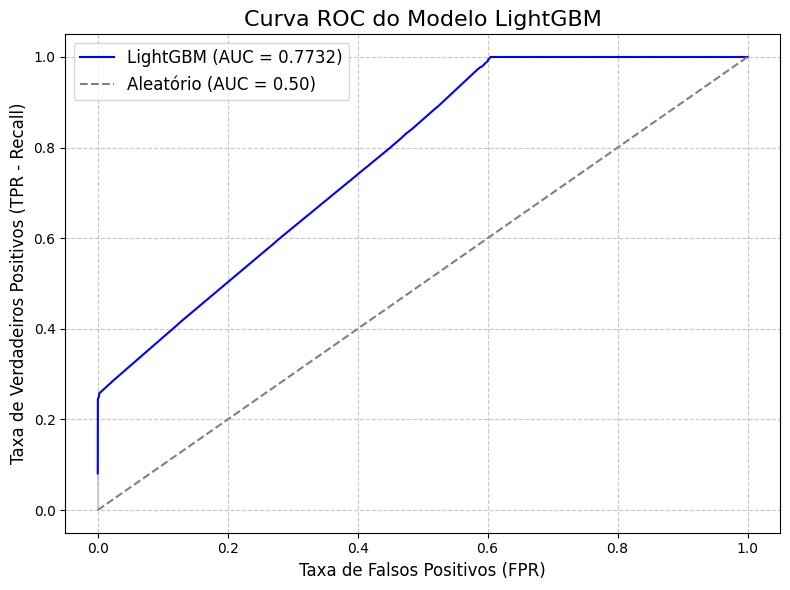

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

# ... (Seu código de treinamento e predição do modelo) ...
# y_test e y_proba (probabilidades da classe 1) devem estar definidos

# Calcular ROC curve e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plotar Curva ROC
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'LightGBM (AUC = {auc_score:.4f})', color='blue')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', label='Aleatório (AUC = 0.50)', color='gray')

plt.title('Curva ROC do Modelo LightGBM', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR - Recall)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### 2. O Que o Modelo Aprendeu? Foco no Comportamento

Este gráfico de barras mostra quais variáveis o modelo considera mais importantes para tomar sua decisão de risco. O foco do modelo agora está onde ele deveria estar: no comportamento recente do cliente, e não em características estáticas.

scr_tcr_implicita (Dívida Total vs. Renda Presumida): É a variável mais importante. Isso significa que a dívida total que o cliente está acumulando, em relação ao que presumimos ser sua renda, é o sinal mais forte de que o cliente entrará em dificuldades.

gasto_crescim_3m & scr_crescim_divida_3m (Crescimento): O modelo valoriza muito a trajetória. Um aumento rápido no uso do cartão e na dívida total nos últimos 3 meses é um alarme vermelho muito claro.

O modelo ignora características irrelevantes (como Região ou Idade), focando 100% nas tendências financeiras da vida do cliente.

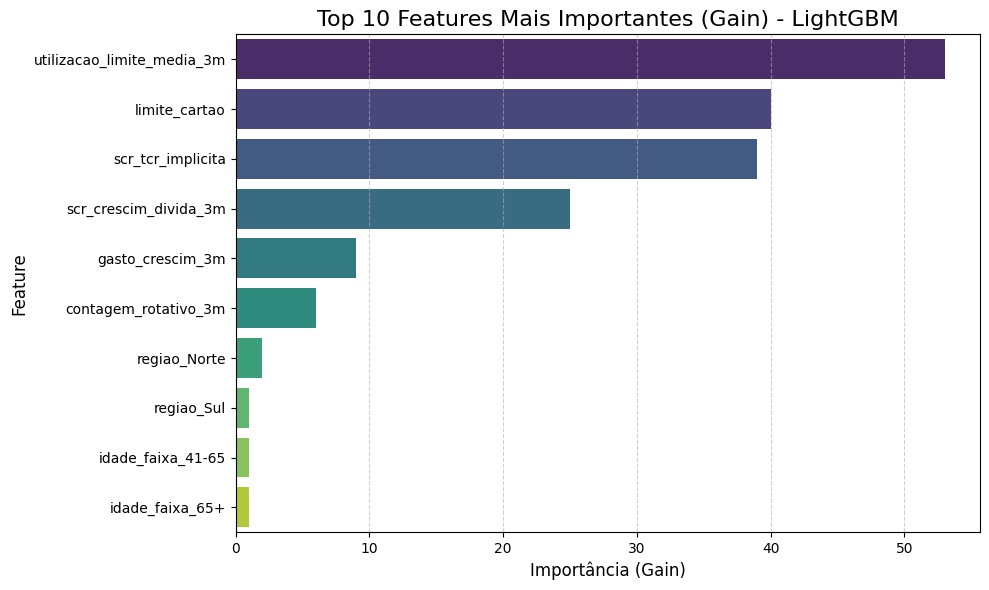

In [59]:
# O DataFrame feature_imp deve ter sido calculado na seção anterior:
# feature_imp = pd.DataFrame({'feature': X_train.columns, 'importance': lgbm.feature_importances_})
# feature_imp = feature_imp.sort_values(by='importance', ascending=False)

# Selecionar o Top 10 para visualização
top_n = 10
df_plot = feature_imp.head(top_n)

plt.figure(figsize=(10, 6))
# Usamos seaborn para um estilo de barra mais agradável
sns.barplot(x='importance', y='feature', data=df_plot, palette='viridis')

plt.title(f'Top {top_n} Features Mais Importantes (Gain) - LightGBM', fontsize=16)
plt.xlabel('Importância (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 3. O Impacto Financeiro: Capturando o Risco no Momento Certo

Esta matriz mostra os resultados de nossas previsões no período de teste (Meses 18 a 23), usando o threshold ideal de $0.20$ para maximizar o Recall (captura de risco).

- Verdadeiros Positivos (TP - Nossos Acertos): Clientes que iriam entrar no Rotativo e que nosso modelo identificou corretamente. Este é o grupo que vamos abordar com a Oferta de Parcelamento antes que o rotativo aconteça. Isso representa o risco evitado e a receita retida.

- Falsos Positivos (FP - Nosso Custo): Clientes que não iriam entrar no Rotativo, mas que foram classificados como risco. É o custo de abordar um cliente desnecessariamente. Nosso objetivo é manter este número o mais baixo possível, sem perder a captura de risco (TP).

O equilíbrio atual maximiza a captura de clientes de risco (TP), permitindo que a área de Negócio possa agir preventivamente.

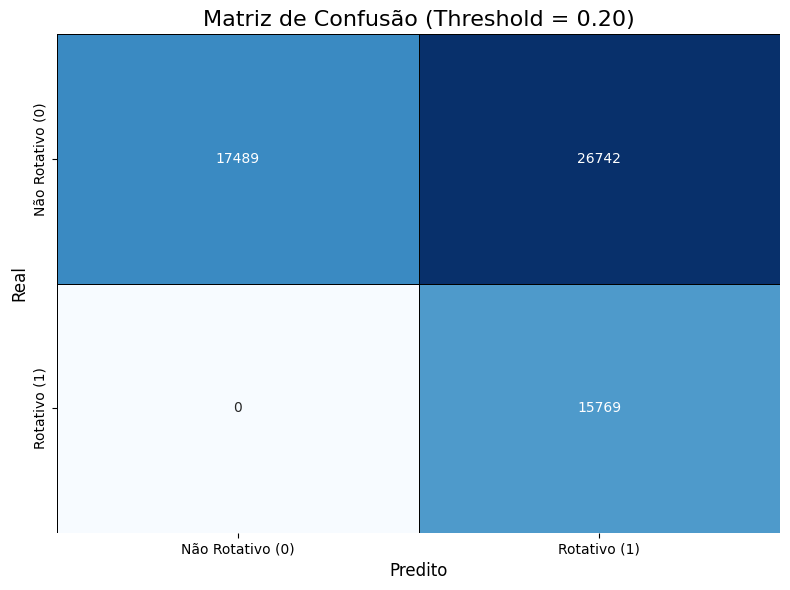

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# O y_test (valores reais) e y_pred (predição com threshold 0.20) já devem estar definidos
# THRESHOLD_OTIMIZADO = 0.20 
# y_pred = (y_proba >= THRESHOLD_OTIMIZADO).astype(int)

# Calcular a Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# Nomes das classes
labels = ['Não Rotativo (0)', 'Rotativo (1)']

plt.figure(figsize=(8, 6))
# Cria o heatmap
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=labels, 
    yticklabels=labels,
    cbar=False, # Não precisamos da barra de cor lateral
    linewidths=.5, # Adiciona linhas para melhor separação
    linecolor='black'
)

plt.title(f'Matriz de Confusão (Threshold = {THRESHOLD_OTIMIZADO:.2f})', fontsize=16)
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.tight_layout()
plt.show()